# Using a Temporal Convolutional Network for Daytrading
## Daniel Kalam, Sharvita Paithankar

In [36]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Conv1D, Dropout, Dense, Activation, BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
import pandas as pd
from pandas_datareader import DataReader
import numpy as np
import matplotlib.pyplot as plt
import datetime

## Gathering Data
Getting data for 100 stocks in the date range of April 2nd, 2018 to October 9th, 2020 from yahoo finance.

In [37]:
symbols = ['AAPL', 'TSLA', 'FB', 'GE']# , 'BRK', 'GOOGL', 'INTC', 'AMD', 'HPE', 'ZM',
          #'CAKE', 'AET', 'F', 'KO', 'DDS', 'NVDA', 'NFLX', 'JPM', 'AMZN', 'MSFT']
#TODO: Add 80 more symbols.
source = 'yahoo'
start_date = pd.to_datetime('2019-10-09')
end_date = pd.to_datetime('2020-10-09')
stock_data_training = {}
for symbol in symbols:
    stock_data_training[symbol] = DataReader(symbol, source, start_date, end_date)
symbols2 = ['NFLX', 'JPM', 'AMZN', 'MSFT']
stock_data_validation = {}
for symbol in symbols2:
    stock_data_validation[symbol] = DataReader(symbol, source, start_date, end_date)

Create a data frame for each column in a stock's data frame.

In [38]:
stock_training_input = np.empty((20, 254, 1))
stock_training_output = np.zeros((20, 254, 2))
stock_validation_input = np.empty((20, 254, 1))
stock_validation_output = np.zeros((20, 254, 2))
i = 0
scaler = StandardScaler()
for symbol in stock_data_training:
    close_data = stock_data_training[symbol].Close
    open_data = stock_data_training[symbol].Open
    #stock_data[symbol].drop(axis= 1, columns = ['Close', 'High', 'Low', 'Volume', 'Adj Close'], inplace = True)
    stock_np = stock_data_training[symbol].Open.to_numpy().reshape(254, 1)
    stock_np = scaler.fit_transform(stock_np)
    #if stock_np.shape == stock_training_input[i].shape:
    stock_training_input[i, :, :] = stock_np[:, :]
    for j in range(0, len(close_data)):
        if close_data[j] > open_data[j]:
            stock_training_output[i, j, 0] = 1
            stock_training_output[i, j, 1] = 0
        else:
            stock_training_output[i, j, 0] = 0
            stock_training_output[i, j, 1] = 1
    i+=1
for symbol in stock_data_validation:
    close_data = stock_data_validation[symbol].Close
    open_data = stock_data_validation[symbol].Open
    #stock_data[symbol].drop(axis= 1, columns = ['Close', 'High', 'Low', 'Volume', 'Adj Close'], inplace = True)
    stock_np = stock_data_validation[symbol].Open.to_numpy().reshape(254, 1)
    stock_np = scaler.fit_transform(stock_np)
    #if stock_np.shape == stock_training_input[i].shape:
    stock_validation_input[i, :, :] = stock_np[:, :]
    for j in range(0, len(close_data)):
        if close_data[j] > open_data[j]:
            stock_validation_output[i, j, 0] = 1
            stock_validation_output[i, j, 1] = 0
        else:
            stock_validation_output[i, j, 0] = 0
            stock_validation_output[i, j, 1] = 1
    i+=1

## TensorFlow
### Converting the Data Into Tensors
Turn the data frames into tensorflow datatypes so that they can be processed by tensorflow.

In [39]:
delete = []
for j in range(i, 20):
    delete.append(j)
stock_training_input = np.delete(stock_training_input, delete, axis=0)
stock_training_output = np.delete(stock_training_output, delete, axis=0)

stock_validation_input = np.delete(stock_training_input, delete, axis=0)
stock_validation_output = np.delete(stock_training_output, delete, axis=0)

<ipython-input-39-dbceed9d368c>:7: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  stock_validation_input = np.delete(stock_training_input, delete, axis=0)
<ipython-input-39-dbceed9d368c>:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  stock_validation_output = np.delete(stock_training_output, delete, axis=0)


### Temporal Convolutional Network Class

In [40]:
filter_count = 2 # Amount of filters
final_filter_count = 2
filters = [] # Filter size for each residual block
kernel_size = 10 #Resolution of each filter
level = kernel_size
n = 0
while level <= 254:
    filters.append(filter_count)
    level+=kernel_size + (kernel_size-1)*2**n
    n+=1
filters[-1] = final_filter_count

In [41]:
class ResidualBlock(Layer):
    def __init__(self, filters, kernel_size, strides, dilation_rate, activation,
                trainable, dropout, dtype=None, activity_regularizer=None, **kwargs):
        super(ResidualBlock, self).__init__(trainable, dtype=dtype)
        self.activation = activation
        self.dropout = dropout
        self.filters = filters
        self.adjust_sample = None
        self.layer_norm = BatchNormalization(axis=-1)
        self.dilatedcausal1 = Conv1D(filters,
                                     kernel_size,
                                     strides,
                                     'causal',
                                     dilation_rate=dilation_rate)
        self.dilatedcausal2 = Conv1D(filters,
                                     kernel_size,
                                     strides,
                                     'causal',
                                     dilation_rate=dilation_rate)

    #Make the dropout based on the shape of the input
    def build(self, input_shape):
        self.drop1 = Dropout(self.dropout, input_shape)
        self.drop2 = Dropout(self.dropout, input_shape)
        if input_shape[2]!=filters:
            self.adjust_sample = Dense(self.filters)

    #The residual block processes the input
    def call(self, inputs, training):
        x = self.dilatedcausal1(inputs)
        x = self.layer_norm(x, training)
        x = self.activation(x)
        x = self.drop1(x, training) #If training is False, drop1 simply returns x
        x = self.dilatedcausal2(x)
        x = self.layer_norm(x, training)
        x = self.activation(x)
        x = self.drop2(x, training) #If training is False, drop2 simply returns x
        if self.adjust_sample is not None:
            inputs = self.adjust_sample(inputs)
        return self.activation(x+inputs)
        
class TCN(Model):
    def __init__(self, filters, kernel_size=2, dropout = 0.2, activation='relu',
                trainable=False, dtype=None, name=None,
                activity_regularizer=None, **kwargs):
        super(TCN, self).__init__()
        self.levels = []
        for i in range(0, len(filters)):
            self.levels.append(ResidualBlock(filters[i], kernel_size,
                                             1, 2**i, Activation(activation),
                                             trainable, dropout,
                                             dtype, activity_regularizer))
    
    #Running the input through each residual block
    def call(self, inputs, training=True):
        for r_block in self.levels:
            inputs = r_block(inputs, training)
        return inputs
stock_training_output[0].shape

(254, 2)

In [42]:
tcn_model = TCN(filters, kernel_size, activation='relu', trainable = True, dtype='float')
tcn_model.compile(optimizer='adam', loss = 'mse', metrics=['accuracy'])
tcn_model.fit(stock_training_input, stock_training_output, epochs = 250, validation_data=(stock_validation_input, stock_validation_output))

Epoch 1/250
1/1 [==============================] - 1s 1s/step - loss: 1.2994 - accuracy: 0.5733 - val_loss: 0.2449 - val_accuracy: 0.6383
Epoch 2/250
1/1 [==============================] - 0s 41ms/step - loss: 1.2813 - accuracy: 0.5679 - val_loss: 0.2434 - val_accuracy: 0.5915
Epoch 3/250
1/1 [==============================] - 0s 40ms/step - loss: 1.2068 - accuracy: 0.5832 - val_loss: 0.2416 - val_accuracy: 0.5586
Epoch 4/250
1/1 [==============================] - 0s 37ms/step - loss: 1.1516 - accuracy: 0.5842 - val_loss: 0.2399 - val_accuracy: 0.5359
Epoch 5/250
1/1 [==============================] - 0s 40ms/step - loss: 1.1450 - accuracy: 0.5758 - val_loss: 0.2386 - val_accuracy: 0.5217
Epoch 6/250
1/1 [==============================] - 0s 44ms/step - loss: 1.1717 - accuracy: 0.5792 - val_loss: 0.2373 - val_accuracy: 0.5236
Epoch 7/250
1/1 [==============================] - 0s 42ms/step - loss: 1.1282 - accuracy: 0.5733 - val_loss: 0.2363 - val_accuracy: 0.5281
Epoch 8/250
1/1 [=====

1/1 [==============================] - 0s 43ms/step - loss: 0.4724 - accuracy: 0.6486 - val_loss: 0.2157 - val_accuracy: 0.6914
Epoch 60/250
1/1 [==============================] - 0s 35ms/step - loss: 0.5013 - accuracy: 0.6412 - val_loss: 0.2154 - val_accuracy: 0.6914
Epoch 61/250
1/1 [==============================] - 0s 31ms/step - loss: 0.4430 - accuracy: 0.6501 - val_loss: 0.2152 - val_accuracy: 0.6959
Epoch 62/250
1/1 [==============================] - 0s 33ms/step - loss: 0.4276 - accuracy: 0.6206 - val_loss: 0.2150 - val_accuracy: 0.6978
Epoch 63/250
1/1 [==============================] - 0s 32ms/step - loss: 0.4324 - accuracy: 0.6570 - val_loss: 0.2148 - val_accuracy: 0.6983
Epoch 64/250
1/1 [==============================] - 0s 35ms/step - loss: 0.4020 - accuracy: 0.6245 - val_loss: 0.2146 - val_accuracy: 0.6973
Epoch 65/250
1/1 [==============================] - 0s 36ms/step - loss: 0.3822 - accuracy: 0.6481 - val_loss: 0.2143 - val_accuracy: 0.6998
Epoch 66/250
1/1 [========

1/1 [==============================] - 0s 33ms/step - loss: 0.2577 - accuracy: 0.6673 - val_loss: 0.2090 - val_accuracy: 0.7628
Epoch 118/250
1/1 [==============================] - 0s 41ms/step - loss: 0.2679 - accuracy: 0.6516 - val_loss: 0.2091 - val_accuracy: 0.7638
Epoch 119/250
1/1 [==============================] - 0s 34ms/step - loss: 0.2537 - accuracy: 0.6639 - val_loss: 0.2092 - val_accuracy: 0.7643
Epoch 120/250
1/1 [==============================] - 0s 40ms/step - loss: 0.2609 - accuracy: 0.6535 - val_loss: 0.2093 - val_accuracy: 0.7643
Epoch 121/250
1/1 [==============================] - 0s 37ms/step - loss: 0.2510 - accuracy: 0.6378 - val_loss: 0.2093 - val_accuracy: 0.7653
Epoch 122/250
1/1 [==============================] - 0s 42ms/step - loss: 0.2659 - accuracy: 0.6634 - val_loss: 0.2093 - val_accuracy: 0.7653
Epoch 123/250
1/1 [==============================] - 0s 39ms/step - loss: 0.2637 - accuracy: 0.6373 - val_loss: 0.2094 - val_accuracy: 0.7648
Epoch 124/250
1/1 [=

Epoch 175/250
1/1 [==============================] - 0s 38ms/step - loss: 0.2292 - accuracy: 0.6560 - val_loss: 0.2165 - val_accuracy: 0.7662
Epoch 176/250
1/1 [==============================] - 0s 35ms/step - loss: 0.2277 - accuracy: 0.6658 - val_loss: 0.2165 - val_accuracy: 0.7662
Epoch 177/250
1/1 [==============================] - 0s 38ms/step - loss: 0.2299 - accuracy: 0.6870 - val_loss: 0.2167 - val_accuracy: 0.7662
Epoch 178/250
1/1 [==============================] - 0s 38ms/step - loss: 0.2310 - accuracy: 0.6457 - val_loss: 0.2168 - val_accuracy: 0.7662
Epoch 179/250
1/1 [==============================] - 0s 48ms/step - loss: 0.2350 - accuracy: 0.6639 - val_loss: 0.2169 - val_accuracy: 0.7662
Epoch 180/250
1/1 [==============================] - 0s 36ms/step - loss: 0.2257 - accuracy: 0.6471 - val_loss: 0.2170 - val_accuracy: 0.7662
Epoch 181/250
1/1 [==============================] - 0s 34ms/step - loss: 0.2220 - accuracy: 0.6211 - val_loss: 0.2170 - val_accuracy: 0.7662
Epoch 

1/1 [==============================] - 0s 28ms/step - loss: 0.2192 - accuracy: 0.6403 - val_loss: 0.2191 - val_accuracy: 0.7662
Epoch 233/250
1/1 [==============================] - 0s 37ms/step - loss: 0.2220 - accuracy: 0.6048 - val_loss: 0.2191 - val_accuracy: 0.7662
Epoch 234/250
1/1 [==============================] - 0s 33ms/step - loss: 0.2265 - accuracy: 0.6225 - val_loss: 0.2193 - val_accuracy: 0.7662
Epoch 235/250
1/1 [==============================] - 0s 29ms/step - loss: 0.2222 - accuracy: 0.6511 - val_loss: 0.2193 - val_accuracy: 0.7662
Epoch 236/250
1/1 [==============================] - 0s 30ms/step - loss: 0.2238 - accuracy: 0.6038 - val_loss: 0.2193 - val_accuracy: 0.7662
Epoch 237/250
1/1 [==============================] - 0s 27ms/step - loss: 0.2270 - accuracy: 0.5960 - val_loss: 0.2193 - val_accuracy: 0.7662
Epoch 238/250
1/1 [==============================] - 0s 31ms/step - loss: 0.2193 - accuracy: 0.6457 - val_loss: 0.2194 - val_accuracy: 0.7662
Epoch 239/250
1/1 [=

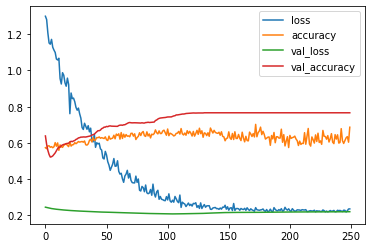

In [43]:
losses = pd.DataFrame(tcn_model.history.history)
losses.plot()